<a href="https://colab.research.google.com/github/KcRenee/FacialKPR/blob/main/FacialKPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# IMPORT LIBRARIES
import zipfile, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

In [3]:
# For reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [6]:
# SETUP PATHS AND UNZIP DATA
base_path = "/content/sample_data"
work_path = "/content/sample_data/working"

# Create the extraction directory if it doesn't exist
import os
if not os.path.exists(work_path):
    os.makedirs(work_path)

# Unzip training.zip
with zipfile.ZipFile(f"{base_path}/training.zip", 'r') as zip_ref:
    zip_ref.extractall(work_path)

# Unzip test.zip
with zipfile.ZipFile(f"{base_path}/test.zip", 'r') as zip_ref:
    zip_ref.extractall(work_path)

print("Extracted files:", os.listdir(work_path))

Extracted files: ['training.csv', 'test.csv']


In [8]:
# LOAD CSV FILES
TRAIN_CSV = f"{work_path}/training.csv"
TEST_CSV  = f"{work_path}/test.csv"
LOOKUP_CSV = f"{base_path}/IdLookupTable.csv"

train = pd.read_csv(TRAIN_CSV)
test  = pd.read_csv(TEST_CSV)
lookup = pd.read_csv(LOOKUP_CSV)

print("TRAIN shape:", train.shape)
print("TEST shape:", test.shape)
print("LOOKUP shape:", lookup.shape)

TRAIN shape: (7049, 31)
TEST shape: (1783, 2)
LOOKUP shape: (27124, 4)


In [9]:
# HELPER FUNCTIONS
def image_from_str(img_str):
    arr = np.fromstring(img_str, sep=' ')
    return arr.reshape(96, 96)

def prepare_images(df):
    imgs = np.stack(df['Image'].apply(lambda s: image_from_str(s)).values)
    imgs = imgs.astype('float32') / 255.0
    imgs = imgs.reshape(-1, 96, 96, 1)
    return imgs

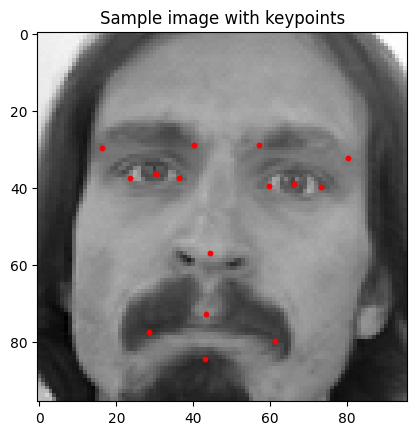

In [10]:
# VISUALIZE SAMPLE IMAGE
sample = train.dropna().iloc[0]
img = image_from_str(sample['Image'])
plt.imshow(img, cmap='gray')
kp = sample.drop('Image').values.astype(float)
plt.scatter(kp[0::2], kp[1::2], c='r', s=10)
plt.title("Sample image with keypoints")
plt.show()

In [11]:
# CLEAN AND PREPARE DATA
train_clean = train.dropna().reset_index(drop=True)
print("After dropna:", train_clean.shape)

X = prepare_images(train_clean)
y = train_clean.drop(columns=['Image']).values.astype('float32')
kp_columns = train_clean.drop(columns=['Image']).columns.tolist()
print("Keypoint columns:", kp_columns)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=SEED
)
print("X_train shape:", X_train.shape, "X_val shape:", X_val.shape)

After dropna: (2140, 31)
Keypoint columns: ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y']
X_train shape: (1819, 96, 96, 1) X_val shape: (321, 96, 96, 1)


In [12]:
# BUILD CNN MODEL
def build_model():
    model = Sequential([
        Input(shape=(96, 96, 1)),
        Conv2D(32, (3 ,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2 ,2),

        Conv2D(64, (3 ,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2 ,2),

        Conv2D(128, (3 ,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2 ,2),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(len(kp_columns))  # 30 keypoints
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,407,390 (13.00 MB)

 Trainable params: 3,406,942 (13.00 MB)

 Non-trainable params: 448 (1.75 KB)

In [15]:
train.isnull().sum()

,0
left_eye_center_x,10
left_eye_center_y,10
right_eye_center_x,13
right_eye_center_y,13
left_eye_inner_corner_x,4778
left_eye_inner_corner_y,4778
left_eye_outer_corner_x,4782
left_eye_outer_corner_y,4782
right_eye_inner_corner_x,4781
right_eye_inner_corner_y,4781


Epoch 1/3


29/29 - 51s - 2s/step - loss: 41.2214 - mae: 4.9935 - val_loss: 1340.0889 - val_mae: 33.8511
Epoch 2/3


29/29 - 79s - 3s/step - loss: 49.0128 - mae: 5.4230 - val_loss: 949.8842 - val_mae: 28.4175
Epoch 3/3


29/29 - 52s - 2s/step - loss: 35.3318 - mae: 4.6037 - val_loss: 676.9327 - val_mae: 23.8098


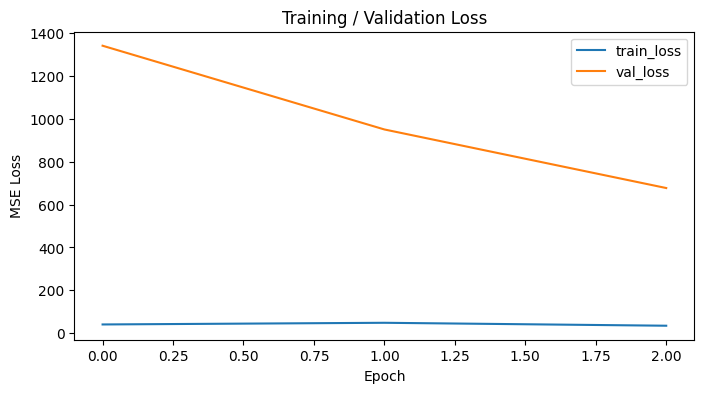

In [17]:
# TRAIN MODEL
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=64,
    callbacks=[es, mc],
    verbose=2
)

# Plot training / validation loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training / Validation Loss')
plt.show()


In [18]:
# PREPARE TEST DATA AND PREDICT
test_images = prepare_images(test)
model.load_weights('best_model.h5')
preds = model.predict(test_images)
print("Predictions shape:", preds.shape)  # should be (n_test, 30)

56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step
Predictions shape: (1783, 30)


In [19]:
# CREATE CORRECT SUBMISSION (CLIPPED TO [0,96])
submission = lookup.copy()

submission['Location'] = submission.apply(
    lambda r: np.clip(
        preds[int(r['ImageId']) - 1, kp_columns.index(r['FeatureName'])],
        0, 96  # clip to valid image coordinates
    ),
    axis=1
)

# Keep only RowId and Location columns
submission = submission[['RowId', 'Location']]
submission.to_csv('submission.csv', index=False)
print("✅ submission.csv ready for Kaggle (coordinates clipped to [0,96])!")

✅ submission.csv ready for Kaggle (coordinates clipped to [0,96])!
